### Municipalities
Municipalities in `SP`, `RJ` are the main focus.
They have the lowest velocity, and largest total orders.

In [1]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import seaborn as sns

from utils import read_customer_seller

In [2]:
def get_state(df: pd.DataFrame, state: str) -> pd.DataFrame:
    final_cols = []
    
    state_df = df[df["cus_state"] == state]
    
    state_df.drop_duplicates(subset=['order_id'])
    
    res = state_df[['cus_lat', 'cus_lng']].copy()
    res['delivery_hours'] = (state_df['order_delivered_customer_date'] - state_df['order_purchase_timestamp']).dt.total_seconds() / 3600
    res.columns = ['lat', 'lng', 'delivery_hours']
    return res

In [3]:
def read_gdf(state: str) -> gpd.GeoDataFrame:
    return gpd.read_file(f"../data/others/geojson/data/{state}.json")

In [4]:
def convert_gdf(df: pd.DataFrame) -> gpd.GeoDataFrame:
    geometry = gpd.points_from_xy(df.lng, df.lat)
    gdf = gpd.GeoDataFrame(
        df,
        geometry=geometry,
        crs="EPSG:4326"
    )
    return gdf

In [20]:
def summarize(df: pd.DataFrame, geo: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    df = gpd.sjoin(df, geo, predicate = "within", how='right')
    
    df = df.groupby(['NOME']).agg({
            'delivery_hours': 'mean',
            'index_left': 'count'
        }).reset_index()

    geo['delivery_hours'] = df['delivery_hours']
    geo['total_orders'] = df['index_left']
    
    return geo

In [21]:
def transform(df: pd.DataFrame, state: str) -> gpd.GeoDataFrame:
    df = get_state(df, state)
    df = convert_gdf(df)
    df = summarize(df,  read_gdf(state))
    
    return df

In [7]:
df = read_customer_seller()
df.head()

,order_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,cus_state,cus_lat,cus_lng,seller_state,seller_lat,seller_lng
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,SP,-23.574809,-46.587471,SP,-23.680114,-46.452454
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,BA,-12.169860,-44.988369,SP,-19.810119,-43.984727
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,GO,-16.746337,-48.514624,SP,-21.362358,-48.232976
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,RN,-5.767733,-35.275467,MG,-19.840168,-43.923299
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,SP,-23.675037,-46.524784,SP,-23.551707,-46.260979


### SP

In [22]:
sp = transform(df, 'SP')

In [23]:
sp.head()

,GEOCODIGO,NOME,UF,geometry,delivery_hours,total_orders
0,3544251,Rosana,SP,"POLYGON ((-52.94769 -22.47289, -52.88534 -22.4...",280.804254,35.0
1,3515350,Euclides da Cunha Paulista,SP,"POLYGON ((-52.77957 -22.60261, -52.7785 -22.59...",248.279889,5.0
2,3554300,Teodoro Sampaio,SP,"POLYGON ((-52.65639 -22.30333, -52.64531 -22.2...",258.418981,9.0
3,3541307,Presidente Epitácio,SP,"POLYGON ((-52.39141 -22.11421, -52.38586 -22.1...",274.157810,17.0
4,3528700,Marabá Paulista,SP,"POLYGON ((-52.28275 -22.2715, -52.27777 -22.26...",196.372037,3.0


#### Delivery Inefficiency by Municipality (Quantile classification)
Although, with quantile classification it's hard to understand a pattern.

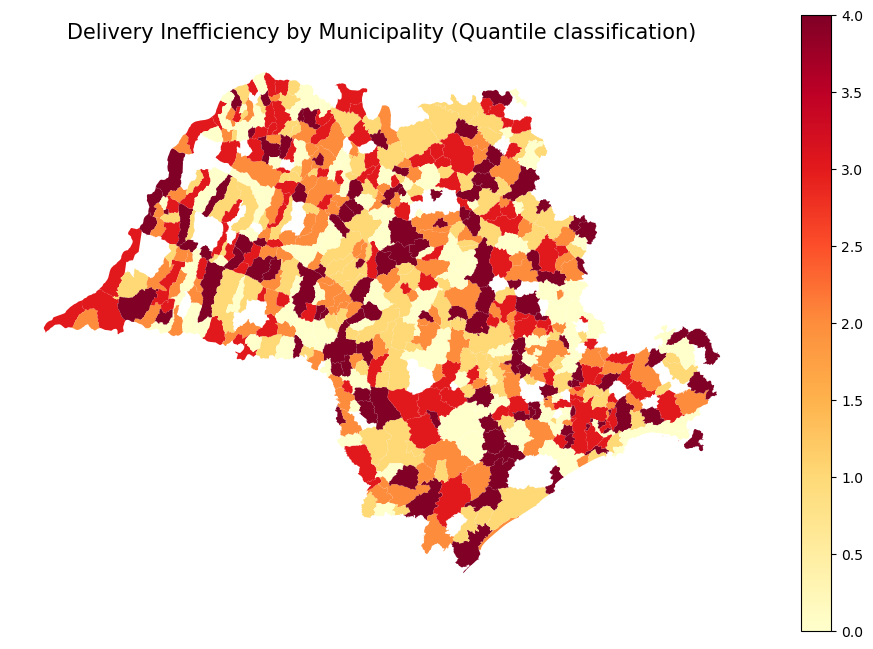

In [25]:
sp['delivery_rank'] = pd.qcut(sp['delivery_hours'], 
                                   q=5,
                                   labels= False)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# 2. Use 'quantiles' to ensure outliers don't dominate the color scale
# 'k=5' creates 5 equal-sized groups of municipalities
sp.plot(column='delivery_rank', 
              ax=ax, 
              legend=True, 
              # scheme='quantiles',  # Crucial for long-tail data
              # k=5, 
              cmap='YlOrRd', 
              # legend_kwds={'title': "Delivery Time Groups", 'loc': 'lower right'}
       )

ax.set_title('Delivery Inefficiency by Municipality (Quantile classification)', fontsize=15)
ax.axis('off')
plt.show()

#### Data Distribution (avg_delivery_hours)
`Box Plot` - Another long tail.

`Histogram` - Nearly bell shaped, most municipalities have less than 400 delivery hours.

I'll try to see which municipalites have those long delivery hours.

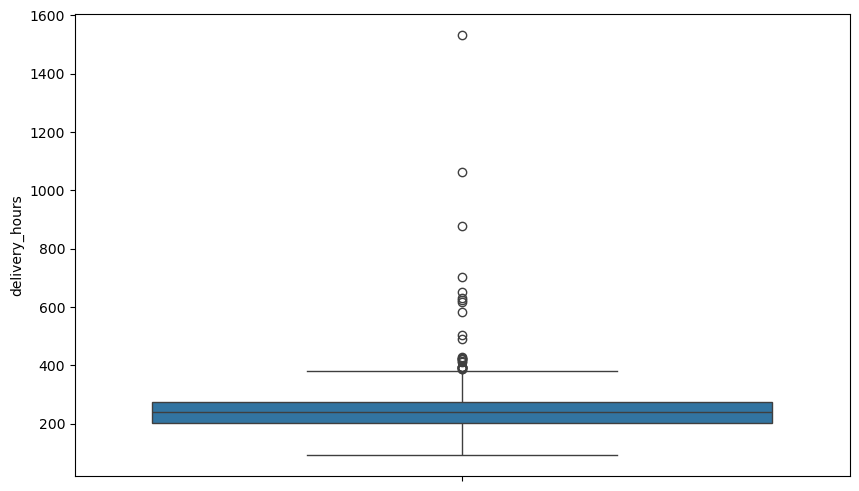

In [26]:
fig, ax = plt.subplots(figsize=(10, 6)) #

sns.boxplot(y='delivery_hours', data=sp, ax = ax)
plt.show()

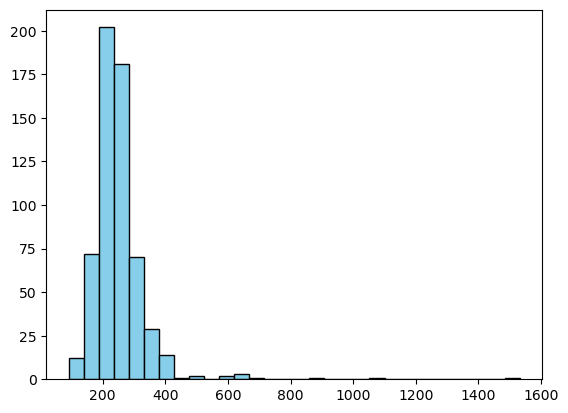

In [27]:
plt.hist(sp[['delivery_hours']] , bins=30, color='skyblue', edgecolor='black')
plt.show()

#### Scatter Plot
Check with a scatter plot to know that there is any realtion with total orders and average delivery hours.
They seems not related.

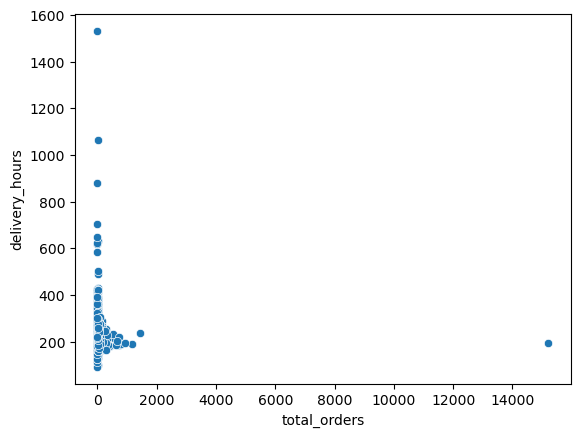

In [28]:
# Create a scatter plot
sns.scatterplot(data=sp, x="total_orders", y="delivery_hours")

# Display the plot
plt.show()

#### Delivery Inefficiency by Municipality 
Coloring municipalites which have longer than 400 dlivery hours.
I'll check the outlier municipalites on a map, to see it they are related by geolocation.

In [37]:
sp = sp.sort_values(by='total_orders', ascending=False)
sp.head(10)

,GEOCODIGO,NOME,UF,geometry,delivery_hours,total_orders,delivery_rank
572,3548104,Santo Antônio do Jardim,SP,"POLYGON ((-46.74672 -22.09239, -46.74343 -22.0...",192.908680,15211.0,0.0
100,3555802,Urânia,SP,"POLYGON ((-50.68303 -20.1924, -50.68057 -20.18...",235.318332,1420.0,2.0
204,3540309,Pontes Gestal,SP,"POLYGON ((-49.81174 -20.19456, -49.81269 -20.1...",191.687085,1154.0,0.0
554,3515186,Espírito Santo do Pinhal,SP,"POLYGON ((-46.8993 -22.24505, -46.89747 -22.20...",193.531612,926.0,0.0
528,3537602,Peruíbe,SP,"POLYGON ((-46.97975 -24.36979, -46.9785 -24.36...",188.337197,783.0,0.0
381,3550209,São Miguel Arcanjo,SP,"POLYGON ((-48.2058 -23.84859, -48.20342 -23.84...",184.253430,736.0,0.0
535,3537602,Peruíbe,SP,"POLYGON ((-46.90998 -24.38025, -46.91085 -24.3...",219.615613,713.0,1.0
563,3550803,São Sebastião da Grama,SP,"POLYGON ((-46.87109 -21.70825, -46.86962 -21.7...",203.867783,675.0,1.0
548,3501905,Amparo,SP,"POLYGON ((-46.86981 -22.58149, -46.86603 -22.5...",187.403904,612.0,0.0
287,3507456,Borebi,SP,"POLYGON ((-49.09534 -22.66602, -49.09195 -22.6...",214.691823,557.0,1.0


In [34]:
Q3 = sp['delivery_hours'].quantile(0.75)
Q1 = sp['delivery_hours'].quantile(0.25)
IQR = Q3 - Q1

upper_bound = Q3 + IQR * 1.5
outliers = sp['delivery_hours'] > upper_bound

highlight = sp[outliers].copy()


In [35]:
# Center point for Nashville
sao_paulo = [-23.56, -46.64]

# Create map
m = folium.Map(location=sao_paulo, zoom_start=10)

folium.Choropleth(
    geo_data=highlight,
    name='outlier municipalities',
    data=highlight,
    columns=['GEOCODIGO', 'delivery_hours'],
    key_on='feature.properties.GEOCODIGO',
    fill_color= 'Reds',
    fill_opacity=0.8,
    line_opacity=1,
).add_to(m)

# Create center column for the centroid of each district
highlight['center'] = highlight.geometry.to_crs(epsg=3578).centroid.to_crs(epsg=4326)

# Build markers and popups
for row in highlight.iterrows():
    row_values = row[1] 
    center_point = row_values['center']
    location = [center_point.y, center_point.x]
    popup = ('Name: ' + str(row_values['NOME']) 
             + ';  ' + 'waiting time: ' + str(row_values['delivery_hours'] / 24) 
             + ';  ' + 'total orders: ' + str(row_values['total_orders'])
    )
    marker = folium.Marker(location = location, popup = popup)
    marker.add_to(m)
    
# Display the map
display(m)


folium.LayerControl().add_to(m)
display(m)

In [38]:
highlight = highlight.sort_values(by='total_orders', ascending=False)
highlight.head()

,GEOCODIGO,NOME,UF,geometry,delivery_hours,total_orders,delivery_rank,center
54,3526506,Lavínia,SP,"POLYGON ((-51.22507 -21.34126, -51.2203 -21.34...",429.396929,18.0,4.0,POINT (-51.03232 -21.14954)
474,3514908,Elias Fausto,SP,"POLYGON ((-47.38883 -22.98163, -47.38484 -22.9...",490.140040,7.0,4.0,POINT (-47.37012 -23.06986)
465,3557006,Votorantim,SP,"POLYGON ((-47.30773 -23.56112, -47.30906 -23.5...",1062.773889,4.0,4.0,POINT (-47.4061 -23.57938)
577,3513801,Diadema,SP,"POLYGON ((-46.64824 -23.72961, -46.63683 -23.7...",385.835139,4.0,4.0,POINT (-46.6109 -23.69646)
52,3528908,Mariápolis,SP,"POLYGON ((-51.24108 -21.7351, -51.24016 -21.73...",392.716667,4.0,4.0,POINT (-51.17116 -21.77874)


### SP - Finding 
The busiest municipalities have the healthy delivery time.

The most slowest municipalities have very low number of total orders, they might not have seperte local hub for delivery.


### RJ